In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import gzip

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            multilabel_confusion_matrix,
                            classification_report,
                            f1_score,
                            plot_confusion_matrix,
                            precision_recall_curve,
                            precision_score,
                            recall_score, roc_curve, 
                            roc_auc_score, 
                            make_scorer)

In [2]:
# Uncomment when using in Google Colab
# from google.colab import files
# uploaded = files.upload()

In [3]:
# Uncomment when using in Google Colab
# import io
# mass = pd.read_csv(io.BytesIO(uploaded['mass_mobile.csv']))


### Load cleaned data from a csv file

In [4]:
mass = pd.read_csv('../data/03_mass_no_country.csv')

In [5]:
mass.head(3)

,id,country,ccode,region,protestnumber,protesterviolence,location,protesteridentity,sources,notes,...,end_date,target,notes_clean,neg,neu,pos,compound,protest_duration,violent_response,violent_count
0,201990001,Canada,20,North America,1,0.0,national,unspecified,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...,...,1990-01-15,"[0, 0, 0, 0, 1, 0, 0]",canada s railway passenger system was finally ...,0.087,0.913,0.000,-0.8176,1,0,0
1,201990002,Canada,20,North America,2,0.0,"Montreal, Quebec",unspecified,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...,...,1990-06-25,"[0, 0, 0, 0, 1, 0, 0]",protestors were only identified as young peopl...,0.000,1.000,0.000,0.0000,1,0,0
2,201990003,Canada,20,North America,3,0.0,"Montreal, Quebec",separatist parti quebecois,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai...",...,1990-07-01,"[0, 0, 0, 0, 1, 0, 0]","the queen, after calling on canadians to remai...",0.060,0.830,0.109,0.7003,1,0,0


In [6]:
# User dataframe of almost all features.

features = mass.drop(columns=['id', 'country', 'ccode', 'region', 'location','protesteridentity', 'sources',
           'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos', 'compound',
           'end_date', 'target', 'arrests', 'accomodation', 'beatings', 'crowddispersal', 'ignore', 'killings', 'shootings', 
           'partipants_number','pop_male', 'pop_female', 'violent_response', 'violent_count', 'protest_duration'])


print(f'X will be set to use {features.shape[1]} features.')

X will be set to use 40 features.


In [7]:
#country_list - this code applies to when using a different csv file that DID included a dummied column for each country
#country_column_names = list(features_1.columns[9:174])
#features = features_1.drop(country_column_names, axis=1)

In [8]:

# This code was initially used to define a small set of features just to get a small model going.
# features = ['pop_density', 'prosperity_2020','partipants_number','compound','region_Europe','region_Central America','region_Africa',
# 'region_MENA', 'region_North America', 'region_Oceania', 'region_South America']
#X = mass[features]

X = features
y = np.array(mass[['arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings']])

y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

In [9]:
len(X)

15179

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### To use a Gridsearch with the MultiOutputClassifer, uncomment the cell below.

In [11]:
# set up MultiOutputClassifier
#model_grad_booster = MultiOutputClassifier(GradientBoostingClassifier())

# Set up hyperparameters
# hyperparameters_grad = dict(estimator__learning_rate=[ 0.2, 0.5], 
#                      estimator__n_estimators=[20, 50, 100],
#                      estimator__min_samples_split=[2, 4, 7, 10],
#                      estimator__max_depth=[5, 20, 30], 
#                      estimator__min_samples_leaf=[ 5, 8, 10],
#                      estimator__min_impurity_decrease=[0.2, 0.6, 0.8],
#                      estimator__max_leaf_nodes=[5, 20, 100])

# Execute Grid Search
# grid_search = GridSearchCV(model_grad_booster, hyperparameters_grad,n_jobs=-1, cv=5, verbose=True,
#                                        pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

# Fit the model
#hyperparameters_tuning = grid_search.fit(X_train, y_train)

#### Current model uses a Randomized CV Search, MultiOutputClassifier of a Random Forest

In [12]:

# set up MultiOutputClassifier
model_random_forest = MultiOutputClassifier(RandomForestClassifier())  

# Set up hyperparameters
hyperparameters_forest = dict(estimator__n_estimators=[20, 50, 100, 200, 300, 500, 1000],
                       estimator__min_samples_split=[2, 4, 7, 10],
                       estimator__max_depth=[3, 5, 10, 15, 20, 30],
                       estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
                       estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
                       estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

# n_iter   int, default=10 - might want to increase?

# Set up Random Search criteria

# Without adding scoring AUC feature
# randomized_search = RandomizedSearchCV(model_random_forest, hyperparameters_forest,
#                                        n_jobs=-1, cv=5, verbose=1, n_iter=30,
#                                        error_score='raise')



randomized_search = RandomizedSearchCV(model_random_forest, hyperparameters_forest,
                                       n_jobs=-1, cv=5, verbose=1, n_iter=30,
                                       error_score='raise',
                                       scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
                                       refit='AUC',
                                       return_train_score=True)


# Fit the model
hyperparameters_tuning = randomized_search.fit(X_train, y_train)

print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

# Set model variable to be the best performing estimator
tuned_model = hyperparameters_tuning.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


Best Parameters = {'estimator__n_estimators': 500, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 10, 'estimator__min_impurity_decrease': 0, 'estimator__max_leaf_nodes': 50, 'estimator__max_depth': 15}


Print best score when using AUC as scoring method.

In [13]:
hyperparameters_tuning.best_score_

0.8148818916702606

#### Get predictions using `X_test` 

In [14]:
y_preds = tuned_model.predict(X_test)

In [15]:
tuned_model.score(X_train, y_train )

0.5572733661278988

In [16]:
tuned_model.score(X_test, y_test)

0.5515151515151515

#### Save four rows of features so we can run a test of using the model after loading its pickle file in another notebook

In [17]:
X_test.iloc[0:4].to_csv('../data/x_sample.csv', index=False)

#### Export tuned model to use for predictions in another notebook.

In [18]:
# save the model to disk

# For some reason this model became 90MB, which was over the 50MB git push limit, 
# so use compression to get the pickle file down to around 20MB

f = gzip.open('../models/01_multi_label_forest_smaller.pickle_zip','wb')
pickle.dump(tuned_model,f)
f.close()

---

In [19]:
# Hat tip to this blog post:
# https://medium.com/@saugata.paul1010/a-detailed-case-study-on-multi-label-classification-with-machine-learning-algorithms-and-72031742c9aa

print("Accuracy = ", accuracy_score(y_test,y_preds))

precision = precision_score(y_test, y_preds, average='micro')
recall = recall_score(y_test, y_preds, average='micro')
f1 = f1_score(y_test, y_preds, average='micro')
 
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy =  0.5515151515151515
Precision: 0.7293, Recall: 0.5229, F1-measure: 0.6091


#### Baseline model

In [20]:
y_train

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [21]:
y_df = pd.DataFrame(data=y, columns=['arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings'])
y_df[0:3]

,arrests,accomodation,beatings,crowddispersal,ignore,killings,shootings
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0


In [22]:
# Sum of all 1's in all columns, divided by the number of rows in the train dataset
pd.DataFrame(y_df.sum() / y_df.shape[0]).T

,arrests,accomodation,beatings,crowddispersal,ignore,killings,shootings
0,0.141182,0.100204,0.052704,0.313459,0.543448,0.054286,0.061335


In [23]:
y.shape

(15179, 7)

In [24]:
y_df.sum(axis=1).value_counts()

1    12270
2     1963
3      689
4      185
5       35
0       29
6        8
dtype: int64

### Print confusion matrix for all target variables (state responses)

The multilabel_confusion_matrix function returns an array of seven confusion matrices (on for each target variable).

Each Seaborn heatmap loads one of the matrices from the array (called `cm_array`)

In [25]:
cm_array = multilabel_confusion_matrix(y_test, y_preds)  # this returns an array of confusion matrices
cm_array[0]

array([[3261,    0],
       [ 526,    8]], dtype=int64)

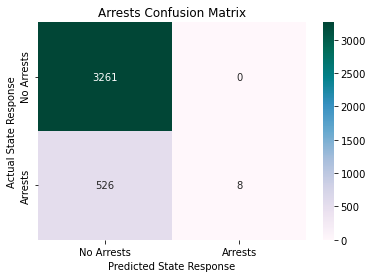

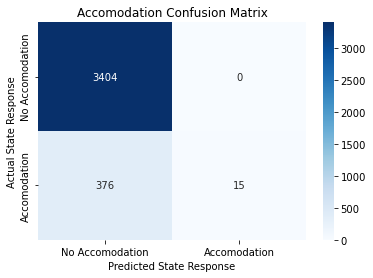

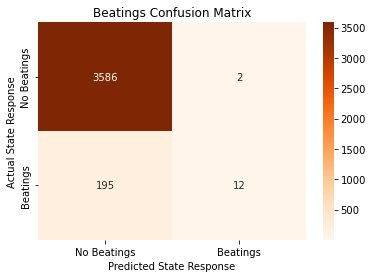

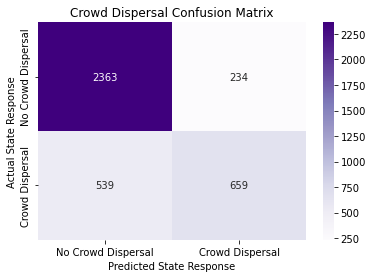

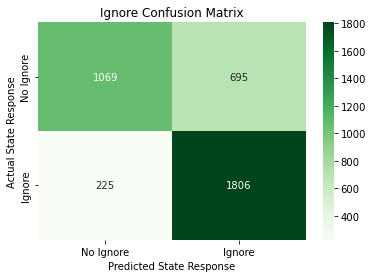

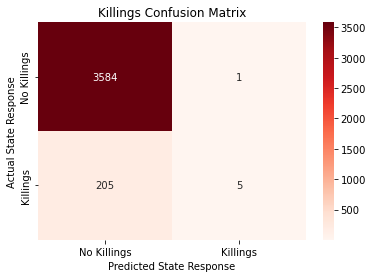

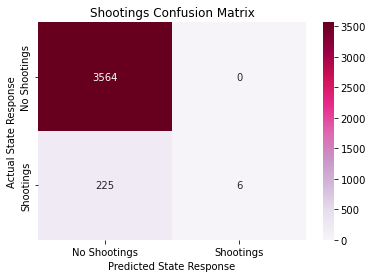

In [26]:
cm_array = multilabel_confusion_matrix(y_test, y_preds)
responses =[('Arrests', 0, 'PuBuGn'), ('Accomodation', 1, 'Blues'), ('Beatings',2, 'Oranges'),
       ('Crowd Dispersal', 3, 'Purples'), ('Ignore', 4, 'Greens'), ('Killings', 5, 'Reds'), ('Shootings', 6, 'PuRd')]
for response, resp_num, cmap in responses:
    fig,ax1 = plt.subplots(1,1, figsize=(6,4))
    plt.subplots_adjust(wspace=0.8)
    sns.heatmap(cm_array[resp_num].astype(int), annot=True, ax = ax1, cmap=cmap, fmt='d'); #annot=True to annotate cells
    plt.title(f'{response} Confusion Matrix')
    plt.xlabel('Predicted State Response')
    ax1.set_ylabel('Actual State Response')
    ax1.xaxis.set_ticklabels([f'No {response}', response])
    ax1.yaxis.set_ticklabels([f'No {response}', response], va='center')
    plt.show();

**Print summary report**

In [27]:
print( classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       534
           1       1.00      0.04      0.07       391
           2       0.86      0.06      0.11       207
           3       0.74      0.55      0.63      1198
           4       0.72      0.89      0.80      2031
           5       0.83      0.02      0.05       210
           6       1.00      0.03      0.05       231

   micro avg       0.73      0.52      0.61      4802
   macro avg       0.88      0.23      0.25      4802
weighted avg       0.80      0.52      0.51      4802
 samples avg       0.66      0.60      0.62      4802



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
